# 특징 벡터화 (quantify)

## BOW ( Bag of words) : 단어의 출현 빈도에 기반한 벡터 표현

* Document ter matrix : 문서 별, 단어 별 출현 빈도

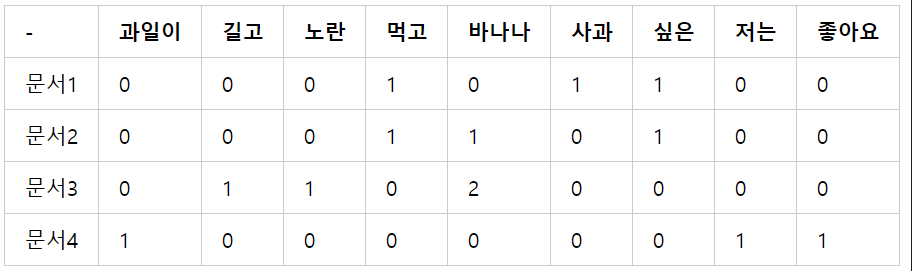

* TF-IDF : 중요도에 따라 달리 빈도를 달리 계산
    * 단어의 문서 내 중요성(weight)을 계산하는 대표적 척도
    * TF(term frequency) : 한 문서에서 어떤 단어가 몇번 나오는가 = 중요도
    * IDF(inverse document frequency): 문서 집합 내에서 그 단어가 몇개의 문서에서 나오는가
* 문장 또는 문서의 벡터화 : 벡터 간의 거리를 통해 유사성 판단

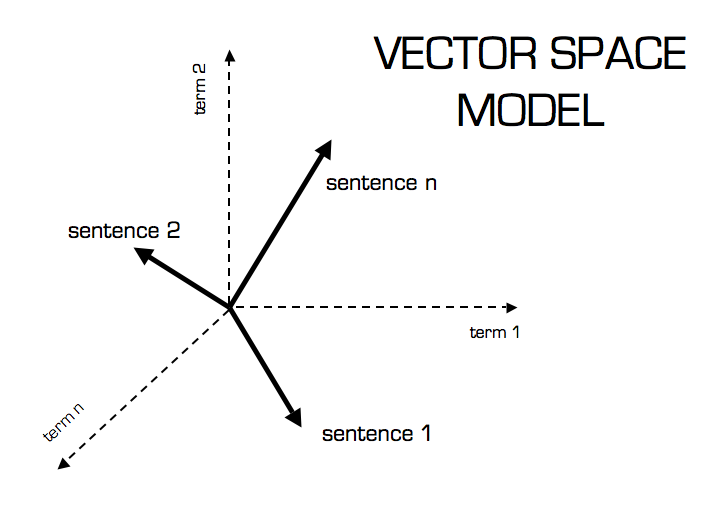

## Wordvec : 개별 단어의 의미를 벡터화

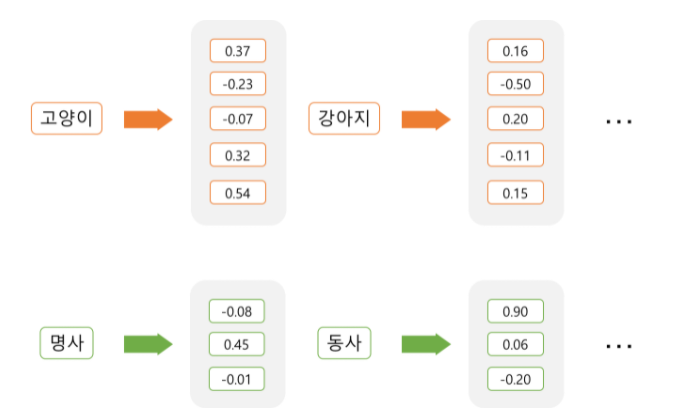

# 감성 분석

* 텍스트에 들어 있는 의견이나 감성, 평가, 태도 등의 주관적인 정보를 컴퓨터를 통해 분석하는 과정

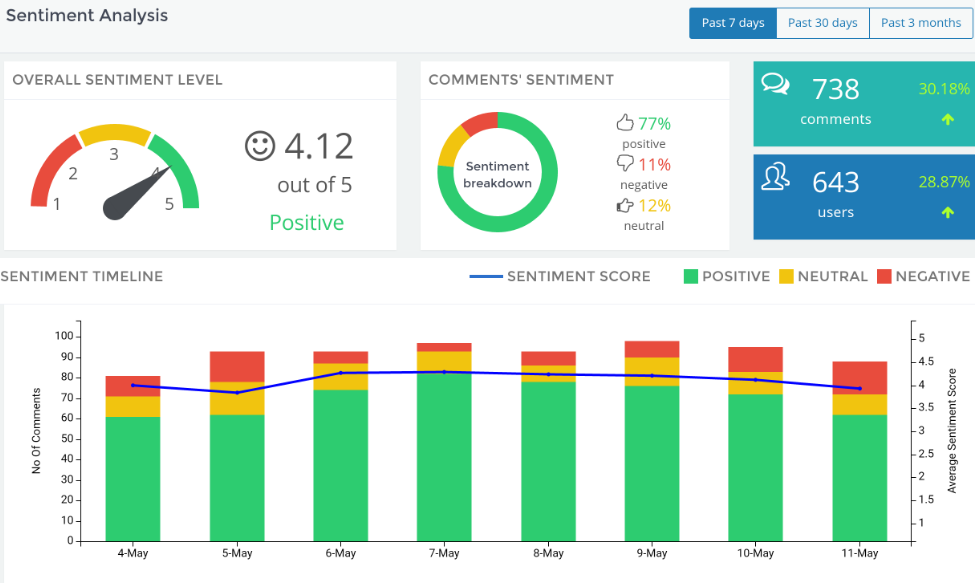



In [1]:
## 한글 UnicodeEncodingError를 방지하기 위해 기본 인코딩을 utf-8로 설정

import os
os.environ["PYTHONIOENCODING"]  = "utf-8"


## 경고 메세지 표시 안하게 설정하기

import warnings
warnings.filterwarnings(action='ignore')


# 1. 데이터 준비 및 탐색

* 네이버 영화평
* https://github.com/e9t/nsmc

In [2]:
import pandas as pd

nsmc_train_df = pd.read_csv('ratings_train.txt', encoding = 'utf8', sep='\t', engine='python')
nsmc_train_df.head()

,id,document,label
0,9976970,아 더빙.. 진짜 짜증나네요 목소리,0
1,3819312,흠...포스터보고 초딩영화줄....오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 ..솔직히 재미는 없다..평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화!스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


In [3]:
nsmc_train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150000 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        150000 non-null  int64 
 1   document  149995 non-null  object
 2   label     150000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.4+ MB


### 'document'칼럼이 Null인 샘플 제거

In [4]:
nsmc_train_df = nsmc_train_df[nsmc_train_df['document'].notnull()]
nsmc_train_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 149995 entries, 0 to 149999
Data columns (total 3 columns):
 #   Column    Non-Null Count   Dtype 
---  ------    --------------   ----- 
 0   id        149995 non-null  int64 
 1   document  149995 non-null  object
 2   label     149995 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 4.6+ MB


### 타겟 컬럼 label 확인(0:부정감성, 1: 긍정감성)

In [5]:
nsmc_train_df['label'].value_counts()

# 갯수 줄이기
nsmc_train_df =nsmc_train_df[:10000]
nsmc_train_df['label'].value_counts()

0    5021
1    4979
Name: label, dtype: int64

In [6]:
import re

nsmc_train_df['document'] = nsmc_train_df['document'].apply(lambda x : re.sub(r'[^ ㄱ-ㅎㅣ가-힣]+', " ", x))
nsmc_train_df.head()

,id,document,label
0,9976970,아 더빙 진짜 짜증나네요 목소리,0
1,3819312,흠 포스터보고 초딩영화줄 오버연기조차 가볍지 않구나,1
2,10265843,너무재밓었다그래서보는것을추천한다,0
3,9045019,교도소 이야기구먼 솔직히 재미는 없다 평점 조정,0
4,6483659,사이몬페그의 익살스런 연기가 돋보였던 영화 스파이더맨에서 늙어보이기만 했던 커스틴 ...,1


## 평가용 데이터 준비


In [7]:
nsmc_test_df = pd.read_csv('ratings_test.txt', encoding='utf8', sep='\t', engine='python')
nsmc_test_df.head()

,id,document,label
0,6270596,굳 ㅋ,1
1,9274899,GDNTOPCLASSINTHECLUB,0
2,8544678,뭐야 이 평점들은.... 나쁘진 않지만 10점 짜리는 더더욱 아니잖아,0
3,6825595,지루하지는 않은데 완전 막장임... 돈주고 보기에는....,0
4,6723715,3D만 아니었어도 별 다섯 개 줬을텐데.. 왜 3D로 나와서 제 심기를 불편하게 하죠??,0


In [8]:
nsmc_test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        50000 non-null  int64 
 1   document  49997 non-null  object
 2   label     50000 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 1.1+ MB


In [9]:
nsmc_test_df = nsmc_test_df[nsmc_test_df['document'].notnull()] # 결측치 제거
nsmc_test_df = nsmc_test_df[:10000] # 갯수 줄이기
print(nsmc_test_df['label'].value_counts())

1    5061
0    4939
Name: label, dtype: int64


In [10]:
# 한글 이외의 문자는 공백으로 변환
nsmc_test_df['document'] = nsmc_test_df['document'].apply(lambda x : re.sub(r'[^ ㄱ-ㅎ|가-힣]+',"",x))

In [11]:
nsmc_test_df['document']

0                                                      굳 ㅋ
1                                                         
2                         뭐야 이 평점들은 나쁘진 않지만 점 짜리는 더더욱 아니잖아
3                                지루하지는 않은데 완전 막장임 돈주고 보기에는
4                만 아니었어도 별 다섯 개 줬을텐데 왜 로 나와서 제 심기를 불편하게 하죠
                               ...                        
9997                    공항 셔틀버스 출입로는  다 있고 등록제인데 안들킨게 비현실적
9998     뜬금없는 좀비의 출현 개연성 없는 스토리 좀비 영화의 바이블이라기에는 개연성이 부족...
9999                                                   개노잼
10000                                         평론가평점에 맞춰보자자
10001    유재석도 유재석이지만 애니영화 중 이렇게 강한 메시지를 줄수있는 영화가 있을까 솔직...
Name: document, Length: 10000, dtype: object

# 분석 모델 구축

# 피처 벡터화 : TF-IDF

* 형태소를 분석하여 토큰화 : 한글 형태소 엔진으로 Okt 이용

In [12]:
from konlpy.tag import Okt

okt = Okt()

def okt_tokenizer(text):
    tokens = okt.morphs(text)
    return tokens

okt_tokenizer(nsmc_test_df['document'][2])


['뭐',
 '야',
 '이',
 '평점',
 '들',
 '은',
 '나쁘진',
 '않지만',
 '점',
 '짜',
 '리',
 '는',
 '더',
 '더욱',
 '아니잖아']

## TF-IDF 기반 피처 벡터 생성

* TfidVectorizer 선언
* fit()
* transform()


In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

# 3개 미만 문서에 나오는 단어 제거, 90%이상 문서에 나오는 단어제거
tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, ngram_range=(1,1), min_df=3, max_df=0.9)
tfidf.fit(nsmc_train_df['document'])
nsmc_train_tfidf = tfidf.transform(nsmc_train_df['document'])
print(nsmc_train_tfidf.shape)


(10000, 5128)


## 감성 분류 모델 구충 : 로지스틱 회귀를 이용한 이진 분류

* Sentiment Analysis using Logistic Regression

### 로지스틱 회귀 기반 분석 모델 생성

In [14]:
from sklearn.linear_model import LogisticRegression

SA_lr = LogisticRegression(random_state = 0)

SA_lr.fit(nsmc_train_tfidf, nsmc_train_df['label'])

LogisticRegression(random_state=0)

### 로지스틱 회귀의 Best 하이퍼파라미터 찾기

In [15]:
from sklearn.model_selection import GridSearchCV

params = {'C': [1,3, 3.5, 4, 4.5, 5]}
SA_lr_grid_cv = GridSearchCV(SA_lr, param_grid=params, cv=3, scoring='accuracy', verbose=1)


### 최적 분석 모델 훈련


In [16]:
SA_lr_grid_cv.fit(nsmc_train_tfidf, nsmc_train_df['label'])

Fitting 3 folds for each of 6 candidates, totalling 18 fits


GridSearchCV(cv=3, estimator=LogisticRegression(random_state=0),
             param_grid={'C': [1, 3, 3.5, 4, 4.5, 5]}, scoring='accuracy',
             verbose=1)

In [17]:
# 최적 파라미터의 best 모델 저장
SA_lr_best = SA_lr_grid_cv.best_estimator_

## 분석 모델 평가

### 평가용 데이터를 이용하여 감성 분석 모델 정확도

In [18]:
nsmc_test_tfidf = tfidf.transform(nsmc_test_df['document'])

In [19]:
test_predict = SA_lr_best.predict(nsmc_test_tfidf)

In [20]:
from sklearn.metrics import accuracy_score

print('감성 분석 정확도 : ', round(accuracy_score(nsmc_test_df['label'], test_predict), 3))

감성 분석 정확도 :  0.794


In [23]:
#st = input('감성 분석할 문장입력 >> ')
st = ["지루하고 심심하다"]


In [24]:
# 1) 입력 텍스트의 피처 벡터화

st_tfidf = tfidf.transform(st)

print (st_tfidf)
# 2) 최적 감성분석 모델에 적용하여 감성 분석 평가
st_predict = SA_lr_best.predict(st_tfidf)

  (0, 4220)	1.0


In [25]:
# 3) 예측 값 출력하기
if(st_predict== 0):
    print(st , "->> 부정 감성")
else :
    print(st , "->> 긍정 감성")

['지루하고 심심하다'] ->> 부정 감성


## 감성 분석2

네이버 API를 이용한 크롤링 프로그램을 이용하여, 코로나로 검색한 결과를 크롤링한 결과

# 데이터 준비 및 탐색

In [26]:
import json


with open('코로나_naver_news.json', encoding='utf8') as j_f:
    data = json.load(j_f)

In [27]:
print(data)

[{'cnt': 1, 'description': '<b>코로나</b>발 경제 위기 대응을 위해 돈 쓸 곳은 늘어났지만, 국세 수입은 줄어들면서 정부의 재정 마련에 대한 우려가 컸다. 이 때문에 한국개발원(KDI) 등 국책연구기관들은 증세를 화두로 꺼내들었지만, 정부 여당은 증세에... ', 'pDate': '2020-06-04 14:12:00', 'title': "결국 '증세론' 먼저 꺼내든 與…&quot;증세없는 '기본소득' 불가능&quot;"}, {'cnt': 2, 'description': '▲ 지난 2일 창녕군보건소 앞에 설치한 선별진료소에서 검사자가 체온을 측정하고 있다.©(사진제공=창녕군청) <b>코로나</b> 장기화 대비 비대면 선별진료 도입 경남 창녕군은 지난 2월 28일 도내 최초로 <b>코로나</b>19 선별진료소... ', 'pDate': '2020-06-04 14:12:00', 'title': '창녕군, ‘창녕형’비대면 선별진료소 운영'}, {'cnt': 3, 'description': "한편, ‘설현’은 최근 <b>코로나</b>19 바이러스를 다룬, MBC ‘시리즈M’ PANDEMIC(세계적 유행)에서 다큐멘터리 내레이션에 처음 도전해 호평을 받았으며, tvN의 새 드라마 '낮과 밤' 출연을 검토중이다. 게임과 이벤트에 대한... ", 'pDate': '2020-06-04 14:12:00', 'title': "DK모바일, 메인 홍보 모델로 AOA '설현' 선정"}, {'cnt': 4, 'description': '변화의 핵심 중에서는 우리 사회가 신종 <b>코로나</b>바이러스 감염증(<b>코로나</b>19)의 위기를 마주하고 있다. 언제 끝이날 지 또 앞으로 어떠한 미래가 펼치질 지 모른다. 국가가 나서서 국민의 어려움을 해결해 줘야 한다. 저희... ', 'pDate': '2020-06-04 14:12:00', 'title': '김병민 &quot;기본소득도 필요하면 논의 테이블에 올려야&quot; [인터뷰]'}, {'cnt': 5, 

In [28]:
data_title =[]
data_description = []

for item in data:
    data_title.append(item['title'])
    data_description.append(item['description'])

In [29]:
data_df = pd.DataFrame({'title':data_title, 'description':data_description})

## 한글 이외 문자 제거

In [30]:
data_df['title'] = data_df['title'].apply(lambda x : re.sub(r'[^ ㄱ-ㅎㅣ가-힣]+|코로나', " ", x))
data_df['description'] = data_df['description'].apply(lambda x : re.sub(r'[^ ㄱ-ㅎㅣ가-힣]+|코로나', " ", x))

data_df.head()  #작업 확인용 출력

,title,description
0,결국 증세론 먼저 꺼내든 증세없는 기본소득 불가능,발 경제 위기 대응을 위해 돈 쓸 곳은 늘어났지만 국세 수입은 줄어들면서 정...
1,창녕군 창녕형 비대면 선별진료소 운영,지난 일 창녕군보건소 앞에 설치한 선별진료소에서 검사자가 체온을 측정하고 있다...
2,모바일 메인 홍보 모델로 설현 선정,한편 설현 은 최근 바이러스를 다룬 시리즈 세계적 유행 에서 ...
3,김병민 기본소득도 필요하면 논의 테이블에 올려야 인터뷰,변화의 핵심 중에서는 우리 사회가 신종 바이러스 감염증 의 위기를 마주하고...
4,이재갑 장관 고용안정지원금 서울센터 방문,이재갑 고용노동부 장관은 월 일 수 시에 긴급 고용안정지원금 서울 센터 서울 ...



# 감성 분석 수행

## title에 대한 감성 분석

In [31]:
# 분석할 데이터의 피처 벡터화

data_title_tfidf = tfidf.transform(data_df['title'])

# 최적 파라미터 학습 모델에 적용하여 감성 분석

data_title_predict = SA_lr_best.predict(data_title_tfidf)

# 감성 분석 결과 값을 데이터 프레임에 저장

data_df['title_label'] = data_title_predict



## description에 대한 감성 분석

In [32]:
# 1) 분석할 데이터의 피처 벡터화 ---<< description >> 분석
data_description_tfidf = tfidf.transform(data_df['description'])

# 2) 최적 파라미터 학습모델에 적용하여 감성 분석
data_description_predict = SA_lr_best.predict(data_description_tfidf)

# 3) 감성 분석 결과값을 데이터 프레임에 저장
data_df['description_label'] = data_description_predict

In [33]:
file_name = 'result_sentimental'
# csv 파일로 저장 ---------------------------------------------
data_df.to_csv(file_name+'.csv', encoding='euc-kr') 

In [34]:
columns_name = ['title','title_label','description','description_label']
NEG_data_df = pd.DataFrame(columns=columns_name)
POS_data_df = pd.DataFrame(columns=columns_name)

for i, data in data_df.iterrows(): 
    title = data["title"] 
    description = data["description"] 
    t_label = data["title_label"] 
    d_label = data["description_label"] 
    
    if d_label == 0: # 부정 감성 샘플만 추출
        NEG_data_df = NEG_data_df.append(pd.DataFrame([[title, t_label, description, d_label]],columns=columns_name),ignore_index=True)
    else : # 긍정 감성 샘플만 추출
        POS_data_df = POS_data_df.append(pd.DataFrame([[title, t_label, description, d_label]],columns=columns_name),ignore_index=True)
     
# 파일에 저장.
NEG_data_df.to_csv(file_name+'_NES.csv', encoding='euc-kr') 
POS_data_df.to_csv(file_name+'_POS.csv', encoding='euc-kr') 

In [35]:
len(NEG_data_df), len(POS_data_df)

(374, 426)

## 감정분석 결과 시각화 : 바차트

In [36]:
POS_description = POS_data_df['description']

POS_description_noun_tk = []

for d in POS_description:
    POS_description_noun_tk.append(okt.nouns(d)) #형태소가 명사인 것만 추출

In [37]:
print(POS_description_noun_tk)  #작업 확인용 출력

[['한편', '설현', '은', '최근', '바이러스', '시리즈', '세계', '유행', '다큐멘터리', '내레이션', '처음', '도전', '호평', '의', '새', '드라마', '낮', '밤', '출연', '검토', '게임', '이벤트', '대한'], ['변화', '핵심', '중', '우리', '사회', '신종', '바이러스', '감염증', '의', '위기', '마주', '언제', '끝', '날', '또', '앞', '미래', '국가', '국민', '어려움', '해결', '저희'], ['경찰', '감염', '우려', '명', '이상', '집회', '봉쇄', '지난', '홍콩', '국가보안법', '시위', '때', '홍콩', '경찰', '확산', '올해', '불허', '상황', '년', '처음', '주최'], ['이번', '행사', '확대', '장기', '화로', '지역', '소비', '판로', '어려움', '농가', '돕기', '등', '소비', '촉진', '위해', '마련', '행사', '계란', '구', '연근', '햇', '감자', '새송이', '방울토마토', '깻잎', '햇', '양파', '오이', '고추', '등', '개', '품목'], ['최근', '갤러리', '현대', '창업', '주년', '기념', '전', '이', '작품', '전시', '의', '영향', '마스크', '착용', '관람객', '미술', '트렌드', '한국', '미술', '시장', '글', '정태희', '서울', '옥션', '스페셜리스트', '세계', '경기', '침체', '여파'], ['감안', '차', '면접', '비대', '역량', '검사', '도입', '국내', '최대', '치킨', '프랜차이즈', '제너시스', '비비큐', '회장', '채용', '관계자', '한국', '대표', '책임감', '브랜드', '로서', '로', '침체', '채용', '분위기'], ['일', '오후', '서울', '중랑구', '의료', '의료', '잠시', '콘서트', '신종', '바이러

In [38]:
POS_description_noun_join = []

for d in POS_description_noun_tk:
    d2 = [w for w in d if len(w) > 1] #길이가 1인 토큰은 제외
    POS_description_noun_join.append(" ".join(d2)) # 토큰을 연결(join)하여 리스트 구성

In [39]:
print(POS_description_noun_join)  #작업 확인용 출력

['한편 설현 최근 바이러스 시리즈 세계 유행 다큐멘터리 내레이션 처음 도전 호평 드라마 출연 검토 게임 이벤트 대한', '변화 핵심 우리 사회 신종 바이러스 감염증 위기 마주 언제 미래 국가 국민 어려움 해결 저희', '경찰 감염 우려 이상 집회 봉쇄 지난 홍콩 국가보안법 시위 홍콩 경찰 확산 올해 불허 상황 처음 주최', '이번 행사 확대 장기 화로 지역 소비 판로 어려움 농가 돕기 소비 촉진 위해 마련 행사 계란 연근 감자 새송이 방울토마토 깻잎 양파 오이 고추 품목', '최근 갤러리 현대 창업 주년 기념 작품 전시 영향 마스크 착용 관람객 미술 트렌드 한국 미술 시장 정태희 서울 옥션 스페셜리스트 세계 경기 침체 여파', '감안 면접 비대 역량 검사 도입 국내 최대 치킨 프랜차이즈 제너시스 비비큐 회장 채용 관계자 한국 대표 책임감 브랜드 로서 침체 채용 분위기', '오후 서울 중랑구 의료 의료 잠시 콘서트 신종 바이러스 감염증 환자 진료 위해 수고 의료 가수 공연 보고 뉴스', '플립 러닝 온라인 학습 교실 토론 심화 학습 거꾸로 교실 불리 포스트 시대 교육 방식 주목 아르고 리더십 상황 게임 통해 리더십 유형', '도배 장판 침대 장롱 가구 교체 예방 방역 진행 주거 환경 조성 미자 양동 동장 이웃 위해 봉사', '사태 가운데 병영 생활 손흥민 경험 영국 화제 손흥민 서로 금방 이서 정말 서로 호흡', '청와대 해외 보가 문재인 대통령 포스트 시대 경제위기 정상회담 통해 양국 협력 에너지 의료 확장 최근 카타르 관련', '맥도날드 방역 작업 대구 지하철 청소 근로자 빅맥 커피 증정 패션 업계 나눔 활동 동참 코오롱 인더스 트리 직원 성과 상금 만원 어려움', '명품 함양 양파 특판전 모습 사진 제공 함양군 함양군 롯데 마트 서울 역점 양파 소비 촉진 판촉 행사 농심 위로 함양군 장기 소비 위축 판매 어려움', '지난 방송 세기 힛트송 노래방 대리 만족 구석 트쏭 주제 노래방 대신 폭발 과거 힛트송 시청자 무료함', '유플러스 언택트 시대 리얼 통해 

#### - 부정 감성의 데이터에서 명사만 추출하여 정리 

In [40]:
NEG_description = NEG_data_df['description']

NEG_description_noun_tk = []
NEG_description_noun_join = []

for d in NEG_description:
    NEG_description_noun_tk.append(okt.nouns(d)) #형태소가 명사인 것만 추출
    
for d in NEG_description_noun_tk:
    d2 = [w for w in d if len(w) > 1]  #길이가 1인 토큰은 제외
    NEG_description_noun_join.append(" ".join(d2)) # 토큰을 연결(join)하여 리스트 구성

In [41]:
print(NEG_description_noun_join)  #작업 확인용 출력

['경제 위기 대응 위해 국세 수입 정부 재정 마련 대한 우려 때문 한국 개발 국책 연구기관 증세 화두 정부 여당 증세', '지난 창녕군 보건소 설치 진료 검사 체온 측정 사진 제공 창녕군 장기 대비 비대 진료 도입 경남 창녕군 지난 도내 최초 진료', '이재 고용노동부 장관 긴급 고용 안정 원금 서울 센터 서울 중구 방문 이번 현장 방문 긴급 고용 안정 원금 신청 시작 이틀', '올해 신종 바이러스 감염증 여파 오프라인 행사 진행 공식 채널 통해 명칭 초청 리스트 공개 한편 반도 국내외', '전국 컨테이너 처리 국내 항만 신종 바이러스 감염증 사태 본격 물동량 부진 와중 인천 중국 항만 정상화', '한편 해외 재료 사재기 국민 먹거리 안정 생산 포스트 과제 부각 농민 기본소득 도입 통해 안정 생산 기반 확충', '이용 의원 제공 이용 민주당 내부 대표 시화 장기 생활 방역 면서 현장 의료 진의 근무 환경 부당 처우 과중 노동 강도 인력 부족 문제', '사태 지속 한의대 강의 역시 대부분 대면 대면 실습 강의실 풍경 예전 현재 대부분 학과 수업 대면', '세계 전례 위기 이로 국내외 영화계 예상 타격 부산 국제 영화제 국내외 상황 인지 예의 주시 정부 방침 권고 준수', '서울 경기 인천 수도권 개척 교회 신종 바이러스 감염증 진자 산발 증가 모양새 감염 경로 진자 방역 당국 긴장', '신종 바이러스 감염증 장기 화로 전통 시장 상인 매출 감소 점포 운영 어려움 투입 오프라인 무료 배송 서비스 운영 지원 지원 대상 남성 사계 시장', '수도권 중심 확산 가운데 주로 노인 참석 다단계 서울시 오늘 오전 기준 진자 감염 경로 수도권', '판매량 급증 이유 신종 바이러스 감염증 확산 주춤 때문 올해 중국 여파 제대로 생산 활동 전개 시간', '이승원 넷마블 대표 신종 바이러스 감염증 확산 언택트 비대 문화 차세대 미래 먹거리 부상 포스트 준비 게임 사가 게임 사의 산업 구조 개편', '정하영 김포시 혁신 교육 지구 사업 특수교육 대상자 사업 별도 편성 소외 학생 면

#### (2) dtm 구성 : 단어 벡터 값을 내림차순으로 정렬

#### - 긍정 감성 데이터에 대한 dtm 구성, dtm을 이용하여 단어사전 구성 후 내림차순 정렬

In [42]:
POS_tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, min_df=2 )
POS_dtm = POS_tfidf.fit_transform(POS_description_noun_join)

POS_vocab = dict() 

for idx, word in enumerate(POS_tfidf.get_feature_names_out()):
    POS_vocab[word] = POS_dtm.getcol(idx).sum()
    
POS_words = sorted(POS_vocab.items(), key=lambda x: x[1], reverse=True)


POS_words  #작업 확인용 출력

[('위해', 14.36737484090034),
 ('의료', 13.470208484531744),
 ('바이러스', 11.982112227900235),
 ('신종', 11.671818535416236),
 ('감염증', 11.01230737972455),
 ('지역', 9.012777769108133),
 ('확산', 8.62812376858293),
 ('이번', 8.29367879447872),
 ('방역', 8.00620937546864),
 ('사회', 7.768403025647608),
 ('시대', 7.688538113208713),
 ('어려움', 7.573067069036933),
 ('극복', 7.264049607709102),
 ('예방', 7.232743046228),
 ('사태', 7.0842675140766165),
 ('포스트', 6.825633899166052),
 ('서울', 6.419184302516365),
 ('경제', 6.315134574471331),
 ('상황', 6.00928857292587),
 ('기업', 5.953519510265087),
 ('대응', 5.838404519271852),
 ('지난', 5.706646427480365),
 ('생활', 5.638159647999816),
 ('올해', 5.573998689618914),
 ('지원', 5.56776463770418),
 ('행사', 5.566749871129112),
 ('온라인', 5.552264589116522),
 ('교육', 5.524395062293579),
 ('오후', 5.512710635332883),
 ('최근', 5.3662894684312725),
 ('사업', 5.358333693796322),
 ('장기', 5.341309140410301),
 ('마스크', 5.222154776390207),
 ('이후', 5.061295206392556),
 ('환자', 5.047266090429023),
 ('공연', 5.037636

In [43]:
NEG_tfidf = TfidfVectorizer(tokenizer = okt_tokenizer, min_df=2 )
NEG_dtm = NEG_tfidf.fit_transform(NEG_description_noun_join)

In [44]:
NEG_vocab = dict() 

for idx, word in enumerate(NEG_tfidf.get_feature_names_out()):
    NEG_vocab[word] = NEG_dtm.getcol(idx).sum()
    
NEG_words = sorted(NEG_vocab.items(), key=lambda x: x[1], reverse=True)

In [45]:
NEG_words   #작업 확인용 출력

[('바이러스', 14.045297846201063),
 ('신종', 12.620216330053031),
 ('감염증', 12.418273224803336),
 ('대종상영화제', 9.096810442574087),
 ('확산', 8.692620291732643),
 ('진자', 8.519979110098108),
 ('위해', 8.443279986241059),
 ('진행', 8.235753073945457),
 ('사태', 7.255736211959352),
 ('여파', 7.097278575006207),
 ('참석', 6.780973551517327),
 ('지난', 6.31634452005154),
 ('온라인', 6.095038923945911),
 ('지역', 5.964208146986902),
 ('정부', 5.701236072421212),
 ('감염', 5.6705535328591505),
 ('이번', 5.515348611053009),
 ('최근', 5.424561595339918),
 ('지원', 5.396674275384298),
 ('통해', 5.3024220753609965),
 ('운영', 5.166449914706263),
 ('관련', 5.12220767923603),
 ('방역', 4.753920248758353),
 ('경제', 4.702211648299164),
 ('예정', 4.700048436375625),
 ('시장', 4.692103846474854),
 ('국내', 4.677422116758791),
 ('수도권', 4.53280075331607),
 ('개발', 4.457322259829908),
 ('기업', 4.367504411554227),
 ('판매', 4.3434698125520335),
 ('시간', 4.328304511149965),
 ('병원', 4.30502495070836),
 ('생활', 4.199445748819928),
 ('위기', 4.17939590768936),
 ('발생', 4.

In [49]:
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm

# fm.get_fontconfig_fonts()
font_location = 'C:/Windows/Fonts/malgun.ttf'
font_name = fm.FontProperties(fname=font_location).get_name()
matplotlib.rc('font', family=font_name)

max = 15  #바 차트에 나타낼 단어의 수 

ImportError: cannot import name 'axes' from 'matplotlib' (c:\Users\JORON\anaconda3\lib\site-packages\matplotlib\__init__.py)

In [48]:
!pip install matplotlib

  Using cached matplotlib-3.7.1-cp310-cp310-win_amd64.whl (7.6 MB)


ERROR: Could not install packages due to an OSError: [WinError 5] 액세스가 거부되었습니다: 'C:\\Users\\JORON\\anaconda3\\Lib\\site-packages\\matplotlib\\ft2font.cp310-win_amd64.pyd'
Consider using the `--user` option or check the permissions.



In [ ]:


plt.bar(range(max), [i[1] for i in POS_words[:max]], color="blue")
plt.title("긍정 뉴스의 단어 상위 %d개" %max, fontsize=15)
plt.xlabel("단어", fontsize=12)
plt.ylabel("TF-IDF의 합", fontsize=12)
plt.xticks(range(max), [i[0] for i in POS_words[:max]], rotation=70)

plt.show()

ImportError: cannot import name 'backend_agg' from 'matplotlib.backends' (c:\Users\JORON\anaconda3\lib\site-packages\matplotlib\backends\__init__.py)

In [ ]:
plt.bar(range(max), [i[1] for i in NEG_words[:max]], color="red")
plt.title("부정 뉴스의 단어 상위 %d개" %max, fontsize=15)
plt.xlabel("단어", fontsize=12)
plt.ylabel("TF-IDF의 합", fontsize=12)
plt.xticks(range(max), [i[0] for i in NEG_words[:max]], rotation=70)

plt.show()

ImportError: cannot import name 'backend_agg' from 'matplotlib.backends' (c:\Users\JORON\anaconda3\lib\site-packages\matplotlib\backends\__init__.py)